In [1]:
#
#
#
#

In [68]:
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [3]:
rawdata = pd.read_csv("../data/titanic/train.csv")
rawdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
print("Unique values for 'SibSp': ",rawdata["SibSp"].unique())
print("Unique values for 'Parch': ",rawdata["Parch"].unique())
print("Max value for 'Fare': ",rawdata["Fare"].max())
print("Min value for 'Fare': ",rawdata["Fare"].min())
print("Max value for 'Age': ",rawdata["Age"].max())
print("Min value for 'Age': ",rawdata["Age"].min())
print("Unique values for 'Pclass': ",rawdata["Pclass"].unique())
print("Unique values for 'Sex': ",rawdata["Sex"].unique())

Unique values for 'SibSp':  [1 0 3 4 2 5 8]
Unique values for 'Parch':  [0 1 2 5 3 4 6]
Max value for 'Fare':  512.3292
Min value for 'Fare':  0.0
Max value for 'Age':  80.0
Min value for 'Age':  0.42
Unique values for 'Pclass':  [3 1 2]
Unique values for 'Sex':  ['male' 'female']


In [6]:
def split(mydata,test_ratio=0.7):
    n = len(mydata)
    shuffled_i = np.random.permutation(n)
    test_no = int(n*test_ratio)
    test_indices = shuffled_i[:test_no]
    train_indices = shuffled_i[test_no:]
    return(mydata.iloc[test_indices],mydata.iloc[train_indices])

In [7]:
def isKid(mydata,age=15):
    mydata["IsKid"] = [1 if x<15 else 0 for x in mydata["Age"]]
    return(mydata)

In [8]:
def dummy(mydata,col,values):
    for i in values:
        mydata[str(i)] = [1 if x == i else 0 for x in mydata[col]]
    return(mydata)

In [9]:
def isAlone(mydata):
    mydata["Alone"] = [1 if mydata["SibSp"][x] == 0 and mydata["Parch"][x] == 0 else 0 for x in range(len(mydata))]
    return(mydata)

In [10]:
def segmentAge(mydata):
    mydata["AgeSeg"] = [round(int(x),-1) for x in mydata["Age"]]
    return(mydata)



In [ ]:
tempdat = dummy(tempdat,"Embarked",list(tempdat["Embarked"].unique()))

In [ ]:
len(tempdat["Name"][1].split("(")[1])

In [11]:
def nameLength(mydata):
    mydata["Name Length"] = [len(x.split("(")[1]) if "(" in x else len(x) for x in mydata["Name"]]
    return(mydata)

In [12]:
rawdata["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [13]:
def scaleData(mydata,col):
    mydata[col] /= mydata[col].max()
    return(mydata)



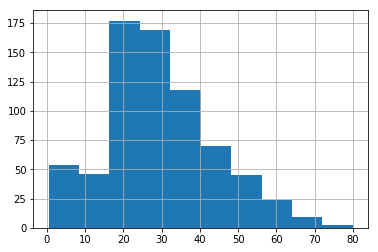

In [14]:
rawdata["Age"].hist()
plt.show()

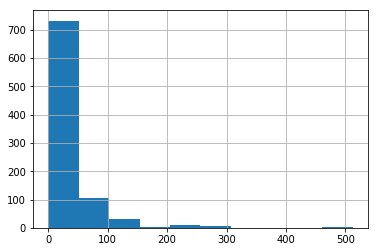

In [15]:
rawdata["Fare"].hist()
plt.show()

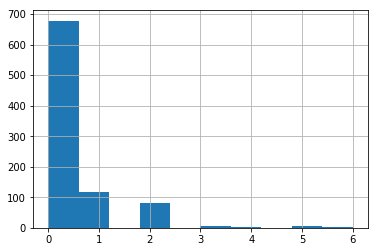

In [16]:
rawdata["Parch"].hist()
plt.show()

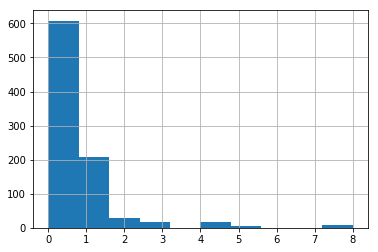

In [17]:
rawdata["SibSp"].hist()
plt.show()

In [18]:
rawdata["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [19]:
# replace NaNs in age

rawdata["Age"].fillna(0,inplace=True)

# supplementary variables

rawdata = nameLength(rawdata)
rawdata = segmentAge(rawdata)

# scale relevant columns

rawdata = scaleData(rawdata,"Age")
rawdata = scaleData(rawdata,"Fare")
rawdata = scaleData(rawdata,"Name Length")

# create dummies

rawdata = dummy(rawdata,"Embarked",list(rawdata["Embarked"].unique()))
rawdata = dummy(rawdata,"Sex",list(rawdata["Sex"].unique()))
rawdata = dummy(rawdata,"Pclass",list(rawdata["Pclass"].unique()))
rawdata = isKid(rawdata,age=18)
rawdata = isAlone(rawdata)


rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Name Length    891 non-null float64
AgeSeg         891 non-null int64
S              891 non-null int64
C              891 non-null int64
Q              891 non-null int64
nan            891 non-null int64
male           891 non-null int64
female         891 non-null int64
3              891 non-null int64
1              891 non-null int64
2              891 non-null int64
IsKid          891 non-null int64
Alone          891 non-null int64
dtypes: float64(3), int64(17), obj

In [20]:
test, train = split(rawdata,test_ratio=0.4)

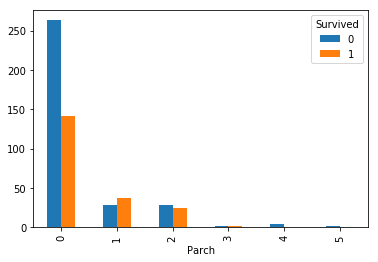

In [21]:
pd.crosstab(train["Parch"],train["Survived"]).plot(kind='bar')

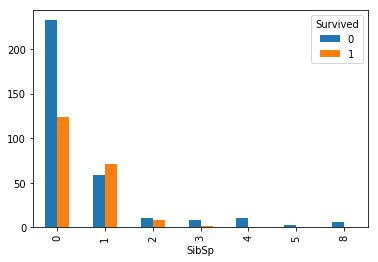

In [22]:
pd.crosstab(train["SibSp"],train["Survived"]).plot(kind='bar')

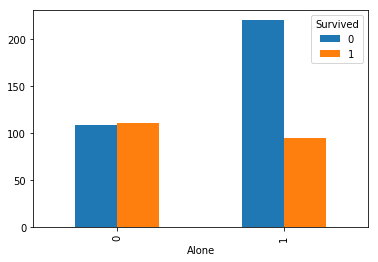

In [23]:
pd.crosstab(train["Alone"],train["Survived"]).plot(kind='bar')

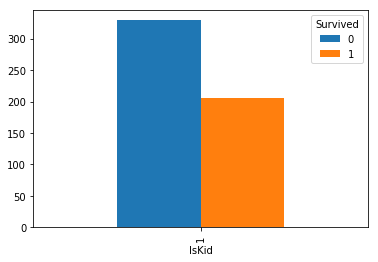

In [24]:
pd.crosstab(train["IsKid"],train["Survived"]).plot(kind='bar')

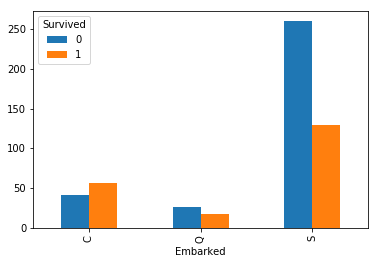

In [25]:
pd.crosstab(train["Embarked"],train["Survived"]).plot(kind='bar')

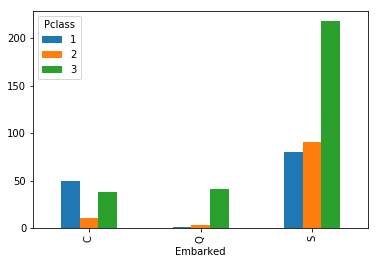

In [26]:
pd.crosstab(train["Embarked"],train["Pclass"]).plot(kind='bar')

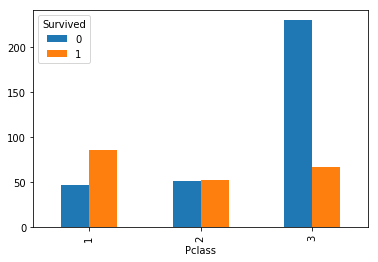

In [27]:
pd.crosstab(train["Pclass"],train["Survived"]).plot(kind='bar')

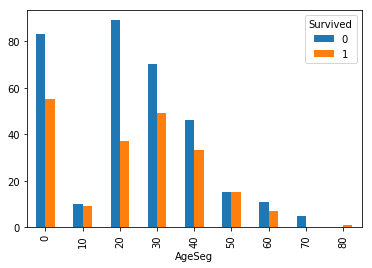

In [28]:
pd.crosstab(train["AgeSeg"],train["Survived"]).plot(kind='bar')
#train["AgeSeg"].value_counts()

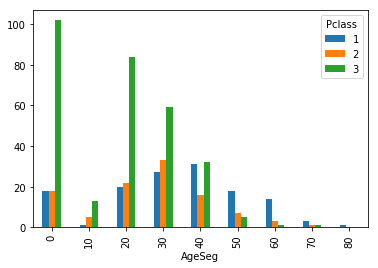

In [74]:
pd.crosstab(train["AgeSeg"],train["Pclass"]).plot(kind='bar')

In [ ]:
train.columns

In [29]:
y = ["Survived"]
x = list(['1','2','3',"Fare","Name Length","male","female","IsKid","Alone","S","C","Q"])
print([i in train.columns for i in x])

[True, True, True, True, True, True, True, True, True, True, True, True]


In [30]:
logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(train[x],train[y])
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
import statsmodels.api as sm
logit_model = sm.Logit(y,x)
result = logit_model.fit()
print(result.summary())

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


TypeError: cannot perform reduce with flexible type

In [32]:
logreg = LogisticRegression()
logreg.fit(train[x],train[y])

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
y_pred = logreg.predict(test[x])
print("Accuracy of logistic regression on test set: {:.2f}".format(logreg.score(test[x],test[y])))

Accuracy of logistic regression on test set: 0.80


In [34]:
# cross validation
kfold = model_selection.KFold(n_splits=10,random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV,train[x],train[y],cv=kfold,scoring=scoring)
print("10-fold cross val accuracy: ",results)

10-fold cross val accuracy:  [ 0.75925926  0.85185185  0.75925926  0.74074074  0.83333333  0.73584906
  0.81132075  0.81132075  0.79245283  0.8490566 ]


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [35]:
results.mean()

0.79444444444444451

In [ ]:
confusion_matrix = confusion_matrix(test[y],y_pred)
print(confusion_matrix)

In [ ]:
print("Coef:", "\t\t\t", "Score:")
for i in range(len(x)):
    print(x[i], "\t\t\t", logreg.coef_[0][i])

In [42]:
### Decision Tree ###
train.columns
dt_x = ["Pclass","male","female","Age","Alone"]

In [53]:
dt = tree.DecisionTreeClassifier(criterion='gini',max_depth=8)
dt.fit(train[dt_x],train[y])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=dt_x)
dotfile.close()

In [54]:
train_dt_predict = dt.predict(train[dt_x])

In [55]:
accuracy_score(train_dt_predict,train[y])

0.87289719626168227

In [65]:
kfold = model_selection.KFold(n_splits=10)
dt2 = tree.DecisionTreeClassifier()
num_trees = 100
bag_model = BaggingClassifier(base_estimator=dt2,n_estimators=num_trees)
bag_results = model_selection.cross_val_score(bag_model,train[dt_x],train[y],cv=kfold)
print(bag_results.mean())

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.771872816212


In [66]:
max_features = 3
rf_model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
rf_results = model_selection.cross_val_score(rf_model,train[dt_x],train[y],cv=kfold)
print(rf_results.mean())

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

0.768099231307


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [67]:
ada_boost_model = AdaBoostClassifier(n_estimators=num_trees)
ada_boost_results = model_selection.cross_val_score(ada_boost_model,train[dt_x],train[y],cv=kfold)
print(ada_boost_results.mean())

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.783053808526


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
grad_boost_model = GradientBoostingClassifier(n_estimators=num_trees)
grad_boost_results = model_selection.cross_val_score(grad_boost_model,train[dt_x],train[y],cv=kfold)
print(results.mean())

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.771907756813


In [71]:
dt_x

['Pclass', 'male', 'female', 'Age', 'Alone']

In [75]:
# base Decision Tree

dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# bagged Tree

dotfile = open("bagged_dt.dot", 'w')
tree.export_graphviz(rf_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Random Forrest

dotfile = open("random_f.dot", 'w')
tree.export_graphviz(bagged_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Ada Boost

dotfile = open("ada_boost.dot", 'w')
tree.export_graphviz(ada_boost_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Stochastic Gradient Boost

dotfile = open("sg_boost.dot", 'w')
tree.export_graphviz(gradient_boost_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [73]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name Length', 'AgeSeg',
       'S', 'C', 'Q', 'nan', 'male', 'female', '3', '1', '2', 'IsKid',
       'Alone'],
      dtype='object')